In [13]:
import torch
import matplotlib.pyplot as plt
from common import *
import time
import copy
import gym

import xarray as xr
import numpy as np

import os
import matplotlib

def do_rollout_push(env, policy, magnitude, rate, num_steps=1000, render=False):
    torch.autograd.set_grad_enabled(False)
    act_list = []
    obs_list = []
    rew_list = []
    x_list = []


    dtype = torch.float32
    obs = env.reset()
    done = False

    for cur_step in range(num_steps):
        
        if np.random.uniform() < rate:
            force = np.random.randn(2)
            force = (force / np.linalg.norm(force))*magnitude
            env.unwrapped.sim.data.xfrc_applied[1,:] = np.array([force[0],0,force[1],0,0,0])
            
        if render:
            env.render()
            time.sleep(.01)
        
        obs = torch.as_tensor(obs, dtype=dtype).detach()
        obs_list.append(obs.clone())
        
        x_list.append(env.unwrapped.sim.data.qpos[0])


        act = policy(obs)
        obs, rew, done, _ = env.step(act.numpy())
        
        act_list.append(torch.as_tensor(act.clone()))
        rew_list.append(rew)


    ep_length = len(rew_list)
    ep_obs = torch.stack(obs_list)
    ep_act = torch.stack(act_list)
    ep_rew = torch.tensor(rew_list, dtype=dtype)
    ep_rew = ep_rew.reshape(-1, 1)

    torch.autograd.set_grad_enabled(True)
    return ep_obs, ep_act, ep_rew, x_list


def do_rollout_noise(env, policy, obs_std=.001, act_std=.01, num_steps=1000, render=False):
    torch.autograd.set_grad_enabled(False)
    act_list = []
    obs_list = []
    rew_list = []
    x_list = []

    dtype = torch.float32
    obs = env.reset()
    done = False
    obs_size = env.observation_space.shape[0]
    act_size = env.action_space.shape[0]

    for cur_step in range(num_steps):
        
        if render:
            env.render()
            time.sleep(.01)
        
        obs = torch.as_tensor(obs, dtype=dtype).detach()
        obs += torch.randn(obs_size)*obs_std
        obs_list.append(obs.clone())
        
        x_list.append(env.unwrapped.sim.data.qpos[0])
        

        act = policy(obs)
        act += torch.randn(act_size)*act_std
        obs, rew, done, _ = env.step(act.numpy())
        
        act_list.append(torch.as_tensor(act.clone()))
        rew_list.append(rew)


    ep_length = len(rew_list)
    ep_obs = torch.stack(obs_list)
    ep_act = torch.stack(act_list)
    ep_rew = torch.tensor(rew_list, dtype=dtype)
    ep_rew = ep_rew.reshape(-1, 1)

    torch.autograd.set_grad_enabled(True)
    return ep_obs, ep_act, ep_rew, x_list

# Variation dimensions

/home/sgillen/anaconda3/lib/python3.7/site-packages/torch/serialization.py:593: SourceChangeWarning: source code of class 'torch.nn.modules.activation.ReLU' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/sgillen/anaconda3/lib/python3.7/site-packages/torch/serialization.py:593: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/sgillen/anaconda3/lib/python3.7/site-packages/torch/serialization.py:593: SourceChangeWarning: source code of class 'torch.nn.modules.activation.ReLU' has changed. you can retrieve the original source code by accessing t

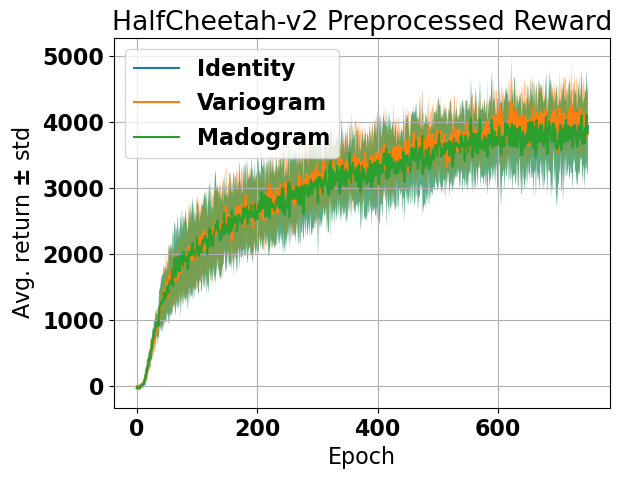

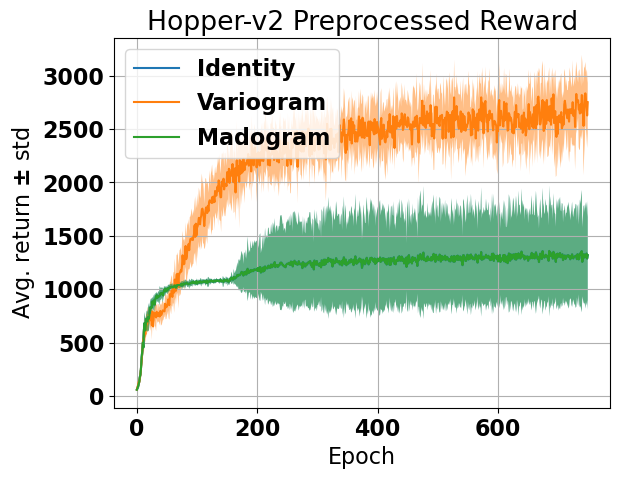

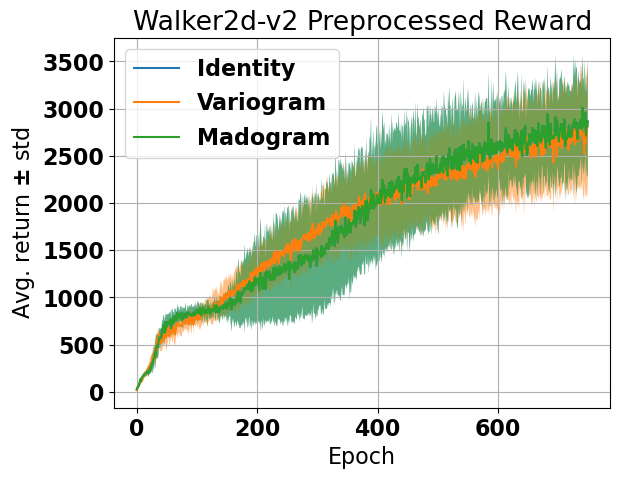

<Figure size 640x480 with 0 Axes>

In [6]:
matplotlib.style.use('default')

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 16}

matplotlib.rc('font', **font)

env_names = ['HalfCheetah-v2', 'Hopper-v2', 'Walker2d-v2']#, 'Ant-v2','Humanoid-v2']
for env_name in env_names:
    data = torch.load(f"./data_noise1/{env_name}.xr")
    data = data.where(data.post!='radodiv', drop=True)

    policy_dict = data.policy_dict
    rews = data.rews#/data.post_rews
    exp_names = [fn.__name__ for fn in data.attrs['post_fns']]
    num_seeds = len(policy_dict[exp_names[0]])

    means = rews.mean(dim="trial")
    stds = rews.std(dim="trial")

    #plt.subplots(1,1, figsize=(10,7))
    plt.plot(means.T)
    plt.legend(['Identity', 'Variogram','Madogram'], loc='upper left')
    ci = stds

    for mean, c in zip(means, ci):
        plt.fill_between([t for t in range(len(mean))], (mean-c), (mean+c), alpha=.5)
    plt.title(f"{env_name} Preprocessed Reward")
    plt.ylabel(r"Avg. return $\pm$ std")
    plt.xlabel(r"Epoch")
    plt.grid()
    plt.figure()

#     for exp_name in exp_names:  
#         plt.plot(rews.loc[exp_name].T[:,0:10])
#         plt.title(exp_name)
#         plt.figure()
#     top_seeds = {'identity':[0,1], 'cdim_div':[0,1]}

In [7]:
for env_name in env_names:
    env = gym.make(env_name)
    data = torch.load(f"./data17/{env_name}.xr")
    policy_dict = data.policy_dict
    init_d = 1e-6
    num_runs = 5; num_seeds=10
    post_fns = [identity, variodiv, madodiv]
    ep_length= 10000


    mshdims = xr.DataArray(np.zeros((len(post_fns), num_seeds, num_runs)),
                    dims = ("post", "seed", "run"),
                    coords = {"post": [fn.__name__ for fn in post_fns]})

    cdims =  xr.DataArray(np.zeros((len(post_fns), num_seeds, num_runs)),
                    dims = ("post", "seed", "run"),
                    coords = {"post": [fn.__name__ for fn in post_fns]})

    vdims = xr.DataArray(np.zeros((len(post_fns), num_seeds, num_runs)),
                    dims = ("post", "seed", "run"),
                    coords = {"post": [fn.__name__ for fn in post_fns]})

    mdims = xr.DataArray(np.zeros((len(post_fns), num_seeds, num_runs)),
                    dims = ("post", "seed", "run"),
                    coords = {"post": [fn.__name__ for fn in post_fns]})

    rdims =  xr.DataArray(np.zeros((len(post_fns), num_seeds, num_runs)),
                    dims = ("post", "seed", "run"),
                    coords = {"post": [fn.__name__ for fn in post_fns]})

    rews =  xr.DataArray(np.zeros((len(post_fns), num_seeds, num_runs)),
                    dims = ("post", "seed", "run"),
                    coords = {"post": [fn.__name__ for fn in post_fns]})

    for post_fn in post_fns:
        for i in range(num_seeds):
            for j in range(num_runs):
                policy = policy_dict[post_fn.__name__][i]
                o,a,r,l = do_long_rollout(env, policy, ep_length=ep_length)
                target = o[200:]
                target = (target - policy.state_means)/(policy.state_std)
                #target = (target - target.mean(dim=0))/(target.std(dim=0))


                rews.loc[post_fn.__name__,i,j] = sum(r).item()

                mshdims.loc[post_fn.__name__,i,j], cdims.loc[post_fn.__name__,i,j] , _, _ = mesh_dim(target)
                mdims.loc[post_fn.__name__,i,j] = variation_dim(target)
                vdims.loc[post_fn.__name__,i,j] = variation_dim(target,order=2)
                rdims.loc[post_fn.__name__,i,j] = variation_dim(target,order=.5)
                

    print(f"{env_name}:")           
    print("madogram dimension")
    for fn in post_fns:
        mean = mdims.mean(dim=('seed','run')).loc[fn.__name__].item()
        std = mdims.std(dim=('seed','run')).loc[fn.__name__].item()
        print(f"{fn.__name__} mean: {mean}, std: {std}")

    print()
    print("variogram dimension")
    for fn in post_fns:
        mean = vdims.mean(dim=('seed','run')).loc[fn.__name__].item()
        std = vdims.std(dim=('seed','run')).loc[fn.__name__].item()
        print(f"{fn.__name__} mean: {mean}, std: {std}")

#     print()
#     print("rodogram dimension")
#     for fn in post_fns:
#         mean = rdims.mean(dim=('seed','run')).loc[fn.__name__].item()
#         std = rdims.std(dim=('seed','run')).loc[fn.__name__].item()
#         print(f"{fn.__name__} mean: {mean}, std: {std}")

    print()
    print("mesh dimension")
    for fn in post_fns:
        mean = mshdims.mean(dim=('seed','run')).loc[fn.__name__].item()
        std = mshdims.std(dim=('seed','run')).loc[fn.__name__].item()
        print(f"{fn.__name__} mean: {mean}, std: {std}")

    print()
    print("cmesh dimension")
    for fn in post_fns:
        mean = cdims.mean(dim=('seed', 'run')).loc[fn.__name__].item()
        std = cdims.std(dim=('seed', 'run')).loc[fn.__name__].item()
        print(f"{fn.__name__} mean: {mean}, std: {std}")

    print()
    print("rewards")
    for fn in post_fns:
        mean = rews.mean(dim=('seed', 'run')).loc[fn.__name__].item()
        std = rews.std(dim=('seed', 'run')).loc[fn.__name__].item()
        print(f"{fn.__name__} mean: {mean}, std: {std}")

    print(); print()

/home/sgillen/anaconda3/lib/python3.7/site-packages/torch/serialization.py:593: SourceChangeWarning: source code of class 'torch.nn.modules.activation.ReLU' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/sgillen/anaconda3/lib/python3.7/site-packages/torch/serialization.py:593: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


HalfCheetah-v2:
madogram dimension
identity mean: 1.426411115370428, std: 0.050773184424985615
variodiv mean: 1.3593603927122226, std: 0.026629905419114214
madodiv mean: 1.311774850411658, std: 0.04882741596623309

variogram dimension
identity mean: 1.7132055576852139, std: 0.025386592212492804
variodiv mean: 1.6796801963561112, std: 0.013314952709557099
madodiv mean: 1.6558874252058289, std: 0.024413707983116532

mesh dimension
identity mean: 2.2637042760535437, std: 0.7058146356065468
variodiv mean: 2.2435139961535593, std: 0.4946590213020088
madodiv mean: 2.097298685080621, std: 0.6466735250007205

cmesh dimension
identity mean: 6.696200131729009, std: 1.1096241602103187
variodiv mean: 6.405103978778657, std: 1.0536868974444302
madodiv mean: 6.359043714533127, std: 0.6803709075408151

rewards
identity mean: 45803.51576915741, std: 18344.714738492068
variodiv mean: 46144.75184234619, std: 14101.971196249695
madodiv mean: 42482.87408691406, std: 19146.366127692854


Hopper-v2:
madogra

# Mesh dimensions

/home/sgillen/anaconda3/lib/python3.7/site-packages/torch/serialization.py:593: SourceChangeWarning: source code of class 'torch.nn.modules.activation.ReLU' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/sgillen/anaconda3/lib/python3.7/site-packages/torch/serialization.py:593: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/sgillen/anaconda3/lib/python3.7/site-packages/torch/serialization.py:593: SourceChangeWarning: source code of class 'torch.nn.modules.activation.ReLU' has changed. you can retrieve the original source code by accessing t

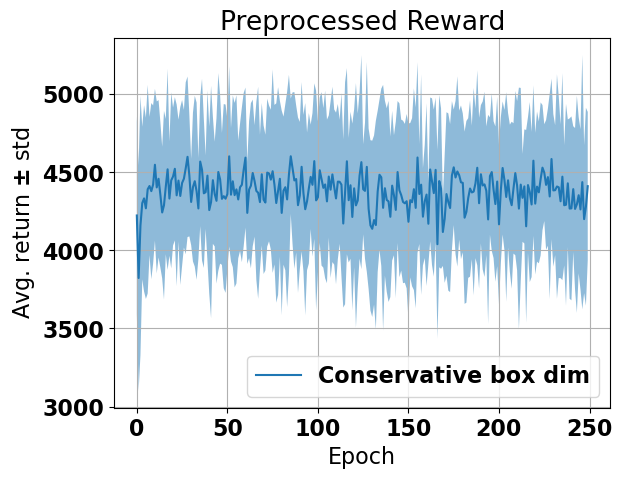

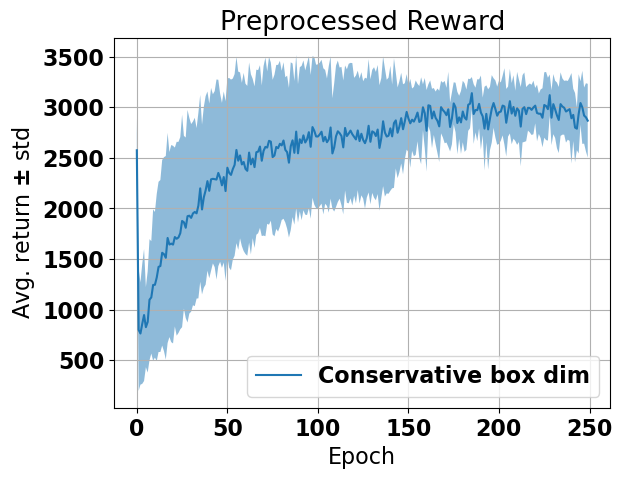

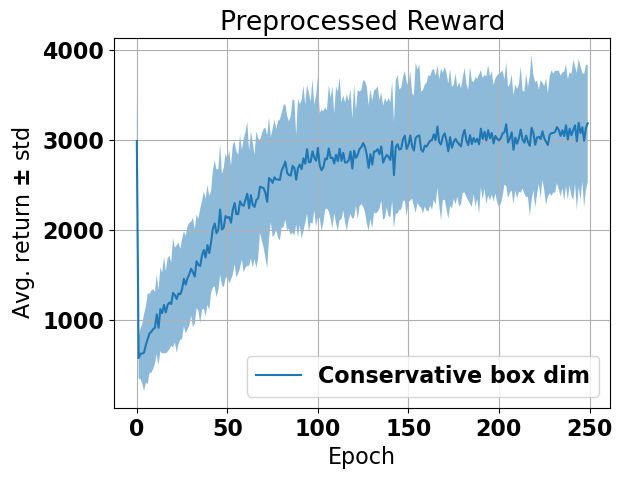

<Figure size 640x480 with 0 Axes>

In [9]:
env_names = ["HalfCheetah-v2", "Hopper-v2", "Walker2d-v2"]#, "Ant-v2"]

matplotlib.style.use('default')

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 16}

matplotlib.rc('font', **font)
init_names = ["identity", "madodiv", "identity", "identity"]

for env_name, init_name in zip(env_names, init_names):
    init_data = torch.load(f"./data_noise1/{env_name}.xr")
    init_policy_dict = init_data.policy_dict
    
    data = torch.load(f"./data_noise1_mdim/{env_name}.xr")
    policy_dict = data.policy_dict
    rews = data.rews#/data.post_rews
    exp_names = [fn.__name__ for fn in data.attrs['post_fns']]
    num_seeds = len(policy_dict[exp_names[0]])

    means = rews.mean(dim="trial")
    stds = rews.std(dim="trial")

    #plt.subplots(1,1, figsize=(10,7))
    plt.plot(means.T)
    plt.legend(['Conservative box dim', 'Box dim'], loc='lower right')
    ci = stds

    for mean, c in zip(means, ci):
        plt.fill_between([t for t in range(len(mean))], (mean-c), (mean+c), alpha=.5)
        
    plt.title(f"Preprocessed Reward")
    plt.ylabel(r"Avg. return $\pm$ std")
    plt.xlabel(r"Epoch")
    plt.grid()
    plt.figure()

    
#     for exp_name in exp_names:  
#         plt.plot(rews.loc[exp_name].T[:,0:10])
#         plt.legend([i for i in range(10)])
#         plt.title(exp_name)
#         plt.figure()
    

In [19]:
env_names = ["HalfCheetah-v2", "Hopper-v2", "Walker2d-v2"]#, "Ant-v2"]
init_names = ["identity", "madodiv", "identity"]#, "identity"]

#env_names = ["Ant-v2"]
#init_names = ["identity"]


init_d = 1e-6
num_runs = 5; num_seeds=10
ep_length= 1000


post_names= ['init', 'mdim_div']
post_fns = [mdim_div]


for env_name, init_name in zip(env_names, init_names):
    env = gym.make(env_name)
    #init_data = torch.load(f"./data_noise1/{env_name}.xr")
    init_data = torch.load(f"./data17/{env_name}.xr")

    init_policy_dict = init_data.policy_dict
    
    #data = torch.load(f"./data_noise1_mdim/{env_name}.xr")
    data = torch.load(f"./data_mcshdim4/{env_name}.xr")

    policy_dict = data.policy_dict
        
    mshdims = xr.DataArray(np.zeros((len(post_fns)+1, num_seeds, num_runs)),
                    dims = ("post", "seed", "run"),
                    coords = {"post": post_names})

    cdims =  xr.DataArray(np.zeros((len(post_fns)+1, num_seeds, num_runs)),
                    dims = ("post", "seed", "run"),
                    coords = {"post": post_names})

    vdims = xr.DataArray(np.zeros((len(post_fns)+1, num_seeds, num_runs)),
                    dims = ("post", "seed", "run"),
                    coords = {"post": post_names})

    mdims = xr.DataArray(np.zeros((len(post_fns)+1, num_seeds, num_runs)),
                    dims = ("post", "seed", "run"),
                    coords = {"post": post_names})

    rdims =  xr.DataArray(np.zeros((len(post_fns)+1, num_seeds, num_runs)),
                    dims = ("post", "seed", "run"),
                    coords = {"post": post_names})

    rews =  xr.DataArray(np.zeros((len(post_fns)+1, num_seeds, num_runs)),
                    dims = ("post", "seed", "run"),
                    coords = {"post": post_names})

    
    for post_fn in post_fns:
        for i in range(num_seeds):
            for j in range(num_runs):
                policy = policy_dict[post_fn.__name__][i]
                o,a,r,l = do_rollout_noise(env, policy, act_std=0.01, obs_std=0.001, num_steps=ep_length)
                target = o[200:]
                #target = (target - target.mean(dim=0))/target.std(dim=0)

                target = (target - policy.state_means)/(policy.state_std)
             
                rews.loc[post_fn.__name__,i,j] = sum(r).item()

                mshdims.loc[post_fn.__name__,i,j], cdims.loc[post_fn.__name__,i,j] , _, _ = mesh_dim(target, init_d=1e-6)
                mdims.loc[post_fn.__name__,i,j] = variation_dim(target)
                vdims.loc[post_fn.__name__,i,j] = variation_dim(target,order=2)
                rdims.loc[post_fn.__name__,i,j] = variation_dim(target,order=.5)
                
    
    for i in range(num_seeds):
        for j in range(num_runs):
            policy = init_policy_dict[init_name][i]
            o,a,r,l = do_rollout_noise(env, policy, act_std=0.01, obs_std=0.001, num_steps=ep_length)

            #o,a,r,l = do_long_rollout(env, policy, ep_length=ep_length)
            target = o[200:]
            target = (target - policy.state_means)/(policy.state_std)
            #target = (target - target.mean(dim=0))/target.std(dim=0)


            rews.loc[post_names[0],i,j] = sum(r).item()

            mshdims.loc[post_names[0],i,j], cdims.loc[post_names[0],i,j] , _, _ = mesh_dim(target, init_d=1e-6)
            mdims.loc[post_names[0],i,j] = variation_dim(target)
            vdims.loc[post_names[0],i,j] = variation_dim(target,order=2)
            rdims.loc[post_names[0],i,j] = variation_dim(target,order=.5)
            
            
    
    print(f"{env_name}:")           
    print("madogram dimension")
    for name in post_names:
        mean = mdims.mean(dim=('seed','run')).loc[name].item()
        std = mdims.std(dim=('seed','run')).loc[name].item()
        print(f"{name} mean: {mean}, std: {std}")

    print()
    print("variogram dimension")
    for name in post_names:
        mean = vdims.mean(dim=('seed','run')).loc[name].item()
        std = vdims.std(dim=('seed','run')).loc[name].item()
        print(f"{name} mean: {mean}, std: {std}")

#     print()
#     print("rodogram dimension")
#     for name in post_names:
#         mean = rdims.mean(dim=('seed','run')).loc[name].item()
#         std = rdims.std(dim=('seed','run')).loc[name].item()
#         print(f"{name} mean: {mean}, std: {std}")

    print()
    print("mesh dimension")
    for name in post_names:
        mean = mshdims.mean(dim=('seed','run')).loc[name].item()
        std = mshdims.std(dim=('seed','run')).loc[name].item()
        print(f"{name} mean: {mean}, std: {std}")

    print()
    print("cmesh dimension")
    for name in post_names:
        mean = cdims.mean(dim=('seed', 'run')).loc[name].item()
        std = cdims.std(dim=('seed', 'run')).loc[name].item()
        print(f"{name} mean: {mean}, std: {std}")

    print()
    print("rewards")
    for name in post_names:
        mean = rews.mean(dim=('seed', 'run')).loc[name].item()
        std = rews.std(dim=('seed', 'run')).loc[name].item()
        print(f"{name} mean: {mean}, std: {std}")

    print(); print()

HalfCheetah-v2:
madogram dimension
init mean: 1.4378865094248439, std: 0.0594231792923772
mdim_div mean: 1.4124861540473452, std: 0.04980229756744875

variogram dimension
init mean: 1.718943254712422, std: 0.02971158964618861
mdim_div mean: 1.7062430770236725, std: 0.024901148783724368

mesh dimension
init mean: 2.3746905108383016, std: 0.4465520190480624
mdim_div mean: 1.520957847325185, std: 0.13548449348882408

cmesh dimension
init mean: 6.670248528539036, std: 1.6685962891736272
mdim_div mean: 3.0052454850066135, std: 0.9787275730371041

rewards
init mean: 5455.066579437256, std: 986.1767787550145
mdim_div mean: 4962.1083984375, std: 574.2809852444633


Hopper-v2:
madogram dimension
init mean: 1.034703619095439, std: 0.013144746745513258
mdim_div mean: 1.191945281856396, std: 0.15004795334042015

variogram dimension
init mean: 1.5173518095477194, std: 0.006572373372756637
mdim_div mean: 1.5959726409281982, std: 0.07502397667021007

mesh dimension
init mean: 1.6577964855615883, std:

In [ ]:
env_names = ["Walker2d-v2"]
init_names = ["identity"]

init_d = 1e-6
num_runs = 5; num_seeds=10
ep_length= 1000

post_names= ['cdim_div', 'mdim_div']
post_fns = [cdim_div, mdim_div]

walking_seeds = {'cdim_div': [0,1,3,4,5,8], 'mdim_div':[0,1,3,4,5,6,8,9]}

for env_name, init_name in zip(env_names, init_names):
    env = gym.make(env_name)
    init_data = torch.load(f"./data17/{env_name}.xr")
    init_policy_dict = init_data.policy_dict
    
    data = torch.load(f"./data_mcshdim4/{env_name}.xr")
    policy_dict = data.policy_dict
        
    mshdims = xr.DataArray(np.zeros((len(post_fns), num_seeds, num_runs)),
                    dims = ("post", "seed", "run"),
                    coords = {"post": post_names})

    cdims =  xr.DataArray(np.zeros((len(post_fns), num_seeds, num_runs)),
                    dims = ("post", "seed", "run"),
                    coords = {"post": post_names})

    vdims = xr.DataArray(np.zeros((len(post_fns), num_seeds, num_runs)),
                    dims = ("post", "seed", "run"),
                    coords = {"post": post_names})

    mdims = xr.DataArray(np.zeros((len(post_fns), num_seeds, num_runs)),
                    dims = ("post", "seed", "run"),
                    coords = {"post": post_names})

    rdims =  xr.DataArray(np.zeros((len(post_fns), num_seeds, num_runs)),
                    dims = ("post", "seed", "run"),
                    coords = {"post": post_names})

    rews =  xr.DataArray(np.zeros((len(post_fns), num_seeds, num_runs)),
                    dims = ("post", "seed", "run"),
                    coords = {"post": post_names})

    
    for post_fn in post_fns:
        for i in walking_seeds[post_fn.__name__]:
            for j in range(num_runs):
                policy = policy_dict[post_fn.__name__][i]
                o,a,r,l = do_long_rollout(env, policy, ep_length=ep_length)
                target = o[200:]
                target = (target - policy.state_means)/(policy.state_std)
             
                rews.loc[post_fn.__name__,i,j] = sum(r).item()

                mshdims.loc[post_fn.__name__,i,j], cdims.loc[post_fn.__name__,i,j] , _, _ = mesh_dim(target, init_d)
                mdims.loc[post_fn.__name__,i,j] = variation_dim(target)
                vdims.loc[post_fn.__name__,i,j] = variation_dim(target,order=2)
                rdims.loc[post_fn.__name__,i,j] = variation_dim(target,order=.5)
                
    

    print(f"{env_name}:")           
    print("madogram dimension")
    for name in post_names:
        mean = mdims.isel(seed=walking_seeds[name]).loc[name].mean(dim=('seed','run')).item()
        std = mdims.isel(seed=walking_seeds[name]).loc[name].std(dim=('seed','run')).item()
        print(f"{name} mean: {mean}, std: {std}")

    print()
    print("variogram dimension")
    for name in post_names:
        mean = vdims.isel(seed=walking_seeds[name]).loc[name].mean(dim=('seed','run')).item()
        std = vdims.isel(seed=walking_seeds[name]).loc[name].std(dim=('seed','run')).item()
        print(f"{name} mean: {mean}, std: {std}")

#     print()
#     print("rodogram dimension")
#     for name in post_names:
#         mean = rdims.isel(seed=walking_seeds[name]).loc[name].mean(dim=('seed','run')).item()
#         std = rdims.isel(seed=walking_seeds[name]).loc[name].std(dim=('seed','run')).item()
#         print(f"{name} mean: {mean}, std: {std}")

    print()
    print("mesh dimension")
    for name in post_names:
        mean = mshdims.isel(seed=walking_seeds[name]).loc[name].mean(dim=('seed','run')).item()
        std = mshdims.isel(seed=walking_seeds[name]).loc[name].std(dim=('seed','run')).item()
        print(f"{name} mean: {mean}, std: {std}")

    print()
    print("cmesh dimension")
    for name in post_names:
        mean = cdims.isel(seed=walking_seeds[name]).loc[name].mean(dim=('seed','run')).item()
        std = cdims.isel(seed=walking_seeds[name]).loc[name].std(dim=('seed','run')).item()
        print(f"{name} mean: {mean}, std: {std}")

    print()
    print("rewards")
    for name in post_names:
        mean = rews.isel(seed=walking_seeds[name]).loc[name].mean(dim=('seed','run')).item()
        std = rews.isel(seed=walking_seeds[name]).loc[name].std(dim=('seed','run')).item()
        print(f"{name} mean: {mean}, std: {std}")

    print(); print()

In [ ]:
seed = 2
ep_length = 10000
policy = policy_dict['identity'][seed]
env = gym.make(env_name)
%time o,a,r,_ = do_long_rollout(env, policy, ep_length= ep_length)
#o,a,r,l = do_rollout(env, policy, render=True)

plt.plot(o[1000:1050])
plt.figure()

target2 = o[200:]
target2 = (target - policy.state_means)/policy.state_std
#target = (target - policy.state_means)/policy.state_std
 
print(sum(r))
m,c,l,d = mesh_dim(target, init_d=1e-9, d_limit=1e-13)
print(m)
print(c)

In [ ]:
seed = 2
ep_length = 10000
policy = policy_dict['mdim_div'][seed]
env = gym.make(env_name)
%time o2,a2,r2,_ = do_long_rollout(env, policy, ep_length= ep_length)

plt.plot(o2[1000:1050])
plt.figure()

target2 = o2[200:]
target2 = (target2 - policy.state_means)/policy.state_std
#target = (target - policy.state_means)/policy.state_std
 
print(sum(r2))
m2,c2,l2,d2 = mesh_dim(target2, init_d=1e-9, d_limit=1e-13)
print(m2)
print(c2)

In [ ]:
# plt.plot(np.log2(d2), np.array(l[:-1]) - np.array(l2),'x-')
# plt.title('log2(d) vs cdiv mesh size')
# plt.figure()

plt.plot(np.log2(d), l,'x-')
plt.plot(np.log2(d2), l2,'x-')
plt.legend(['id', 'mdiv'])
plt.title("log(d) vs mesh size")

plt.figure()

plt.plot(d, l,'x-')
plt.plot(d2, l2,'x-')
plt.legend(['id', 'mdiv'])
plt.title("d vs mesh size")
plt.xlim([0,1])
plt.figure()



#plt.plot(d[:-2], np.array(l[:-2]) - np.array(l3),'x-')
#plt.plot(d[:-2], np.array(l[:-2]) - np.array(l2),'x-')
#plt.xlim([0,1])

#plt.plot(d3, l3,'x-')
#plt.legend(['id', 'mdiv', 'cdiv'])
#plt.title("d vs mesh size")
#plt.xlim([0,1])
#plt.figure()

In [5]:
import time
for seed in range(num_seeds):
    fail=0
    for i in range(10):
        obs, acts, rews, _ = do_long_rollout(env, init_policy_dict['identity'][seed], ep_length=10000)
        #plt.plot(obs)
        if sum(rews) < 0:

        
            fail+=1
            
    print(seed,fail)

Creating window glfw


KeyboardInterrupt: 